In [1]:
# Example using sunkit-spex with my generated spectra/srm for the RHESSI weeflares
# 
# Now using more optimal files....
# 
# 23-Jan-2025 IGH
# 30-Jan-2025 Checked with v0.4.1.dev22
# 09-Oct-2025 Checked with v0.4.1.dev52
# 28-Oct-2025 Now working with more optimal files

In [ ]:
from astropy.time import Time, TimeDelta
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sunpy.io.special import read_genx
from sunkit_spex.extern.rhessi import RhessiLoader
from sunkit_spex.legacy.fitting.fitter import Fitter

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

plt.rcParams.update({'font.size': 18,'mathtext.default':"regular"})

In [3]:
# Times and file names
ftims=Time(['2006-11-17T05:13:28.000','2006-11-17T05:13:52.000'],format='isot')
btims=Time(['2006-11-17T05:11:30.000','2006-11-17T05:12:30.000'],format='isot')

fdir='fits/'
fspec="20061117_051000_spec_sum146_sp.fits"
fsrm="20061117_051000_srm_sum146_sp.fits"

In [4]:
# Some setup for sunxspex
time_profile_size = (9,6)
spec_single_plot_size = (6,8)
spec_plot_size = (16,10)
spec_font_size = 18
default_font_size = 10
xlims, ylims = [3,80], [5e-2,5e2]
tol = 1e-5

In [5]:
rhess_spec = RhessiLoader(spectrum_fn=fdir+fspec, srm_fn=fdir+fsrm)

In [6]:
# Whats the max energy bin of this srm/spec file
maxe=rhess_spec._loaded_spec_data["count_channel_bins"][-1]
print(maxe)

[240. 250.]


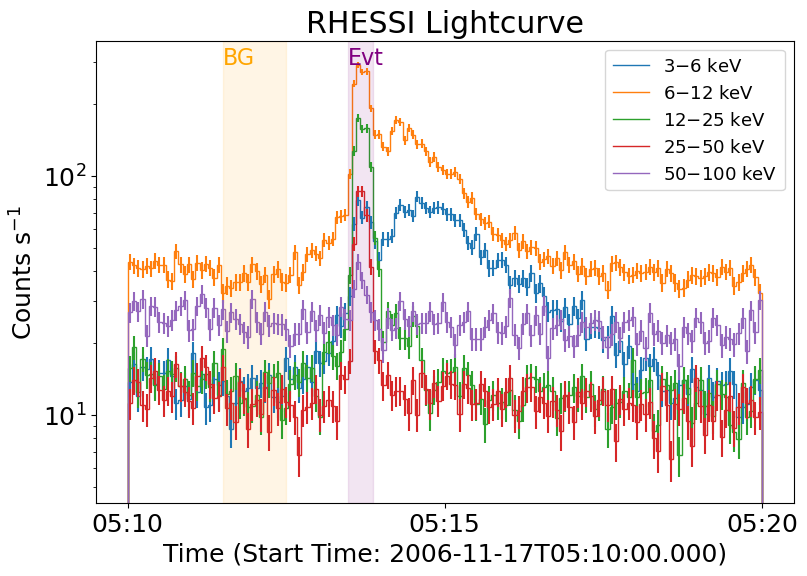

In [7]:
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=time_profile_size)
rhess_spec.update_background_times(btims[0],btims[1])
rhess_spec.update_event_times(ftims[0],ftims[1])
rhess_spec.lightcurve(energy_ranges=[[3,6], [6,12], [12,25],[25,50],[50,100]])
plt.show()
plt.rcParams['font.size'] = default_font_size

In [8]:
fitter = Fitter(rhess_spec)

fitter.model = "(f_vth+thick_fn)"
fitter.loglikelihood = "cstat"
fitter.show_params

Param,Status,Value,Bounds,Error
,,,"(min, max)","(-, +)"
str22,str11,float64,object,object
T1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
EM1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
total_eflux1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
index1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
e_c1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
Fit Stat.,cstat ln(L),0.00e+00,--,--


In [9]:
# Fit setup and ranges optimised for this data and harder microflares
fitter.energy_fitting_range = [4,10]
fitter.params["T1_spectrum1"] = {"Value":10, "Bounds":(7, 20)}
fitter.params["EM1_spectrum1"] = {"Value":1, "Bounds":(1e-2, 1e2)}
fitter.params["total_eflux1_spectrum1"] = {"Status":"fix", "Value":0.9, "Bounds":(1e-2, 1e2)}
fitter.params["index1_spectrum1"] = {"Status":"fix", "Value":6, "Bounds":(2, 12)}
fitter.params["e_c1_spectrum1"] = {"Status":"fix", "Value":15, "Bounds":(5, 30)}
spec_fit = fitter.fit()

# Then non-thermal fit higher energy
fitter.energy_fitting_range = [12,50]
fitter.params["T1_spectrum1"] = "fix"
fitter.params["EM1_spectrum1"] = "fix"
fitter.params["total_eflux1_spectrum1"] = "free"
fitter.params["index1_spectrum1"] = "free"
fitter.params["e_c1_spectrum1"] = "free"
spec_fit = fitter.fit()

# The do the full range
fitter.energy_fitting_range = [4,50]
fitter.params["T1_spectrum1"] = "free"
fitter.params["EM1_spectrum1"] = "free"
fitter.params["total_eflux1_spectrum1"] = "free"
fitter.params["index1_spectrum1"] = "free"
fitter.params["e_c1_spectrum1"] = "free"
spec_fit = fitter.fit()

/Users/iain/github/sunkit-spex/sunkit_spex/legacy/thermal.py:763: UserWarning: Some input energy values outside valid range of 1.0002920302956426--200.15819869050395 keV. Flux will be zero outside this range.
  warnings.warn(message)


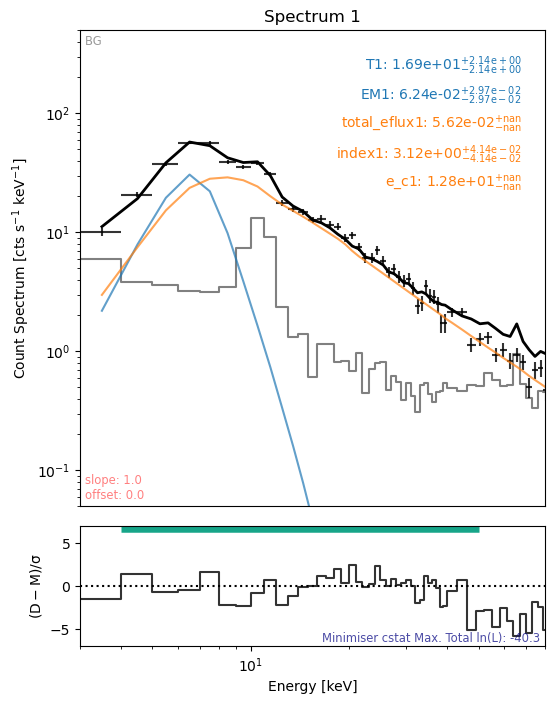

In [10]:
plt.figure(figsize=spec_single_plot_size)
axes, res_axes = fitter.plot()
for a in axes:
    a.set_xlim(xlims)
    a.set_ylim(ylims)
    a.set_xscale("log")
plt.show()

In [11]:
# # Print out the fit results
spec_fit

[16.9090867855492,
 0.062394117392402915,
 0.05622018039228921,
 3.116672115035664,
 12.805642810078126]

In [12]:
# Now do the mcmc
mcmc_result = fitter.run_mcmc(steps_per_walker=1000,walker_spread='mag_order')

100%|██████████| 1000/1000 [02:04<00:00,  8.06it/s]


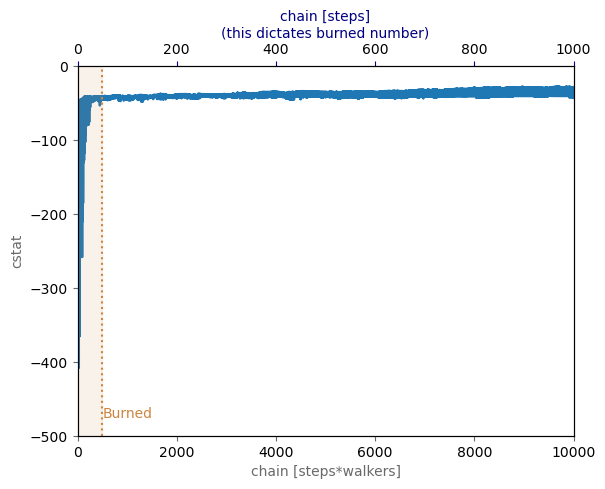

In [13]:
# Look at the log probability to see if enough runs to get stable solution
# Get rid of the first 50 runs in this case
fitter.burn_mcmc = 50
plt.figure()
fitter.plot_log_prob_chain()
plt.ylim([-500,0])
plt.show()

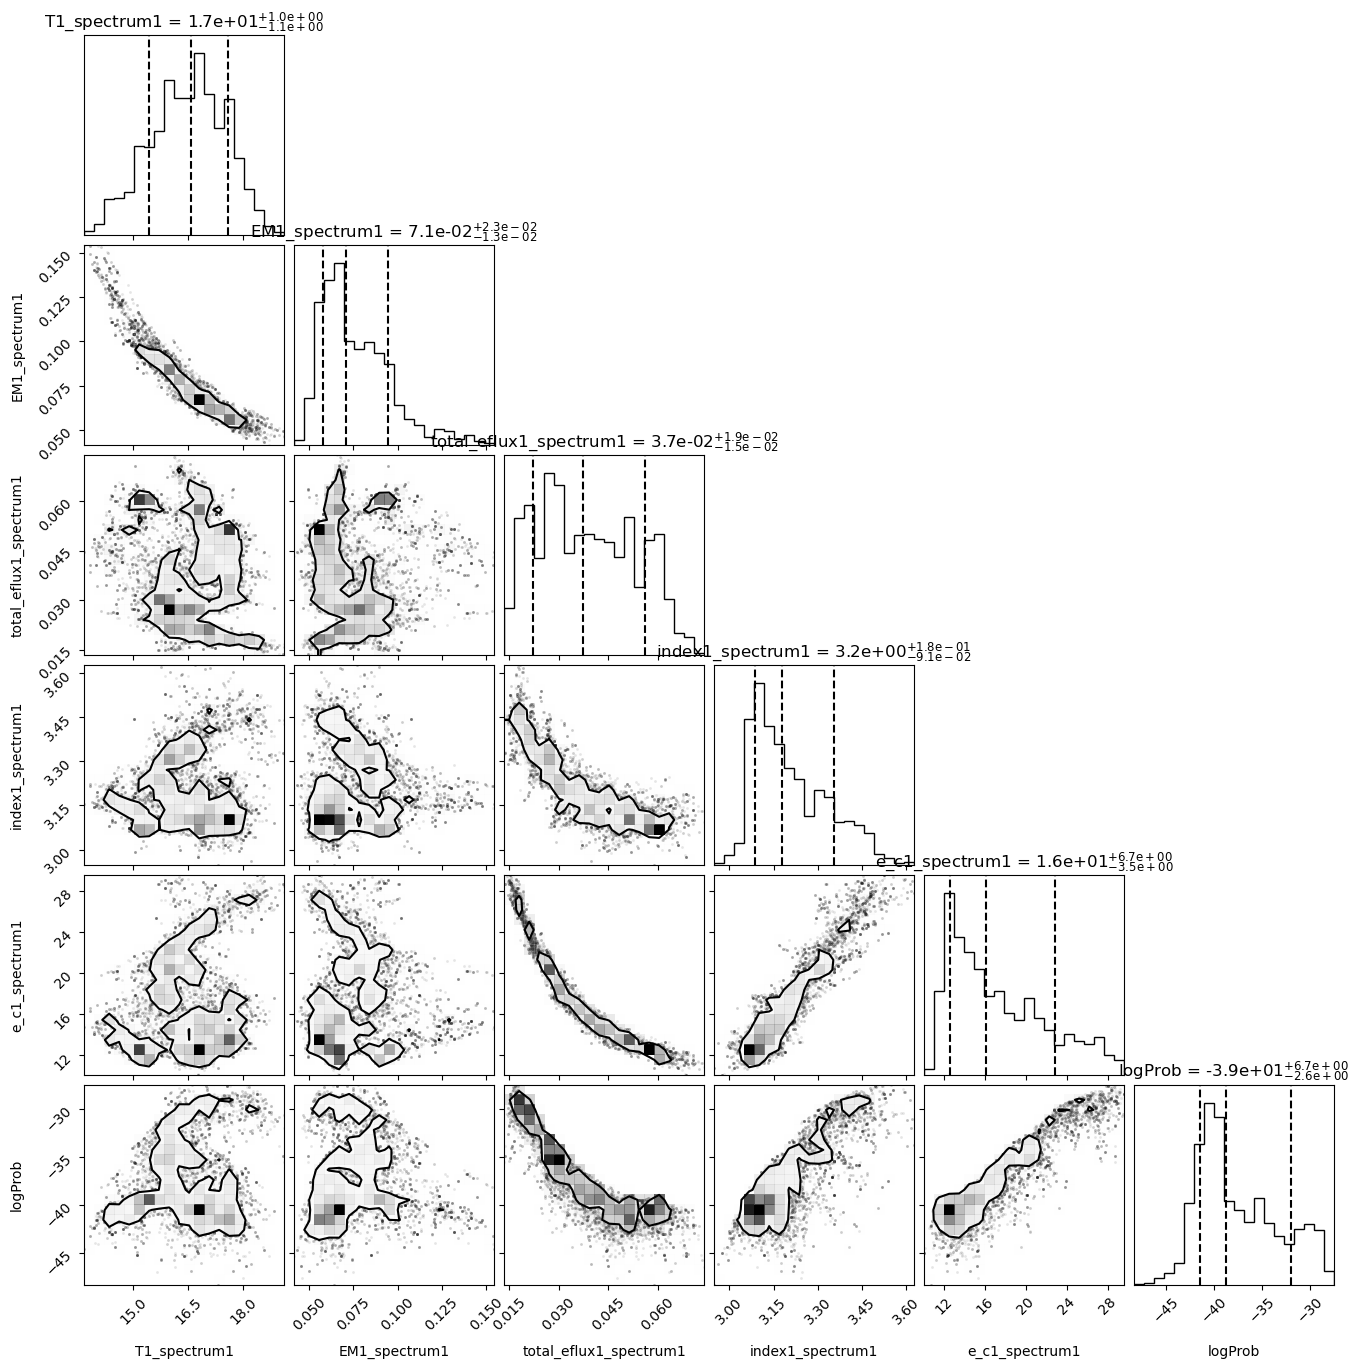

In [14]:
# Look at the results via the corner plot
corner_plot = fitter.corner_mcmc()

In [15]:
# Can save this out if we want
# save_filename = "./sks_weeflare_fit.pickle"
# fitter.save(save_filename)
# 
# And then load back in with
# from sunkit_spex.sunxspex_fitting.fitter import load
# rhessi_reloaded = load(save_filename)

/Users/iain/github/sunkit-spex/sunkit_spex/legacy/thermal.py:763: UserWarning: Some input energy values outside valid range of 1.0002920302956426--200.15819869050395 keV. Flux will be zero outside this range.
  warnings.warn(message)


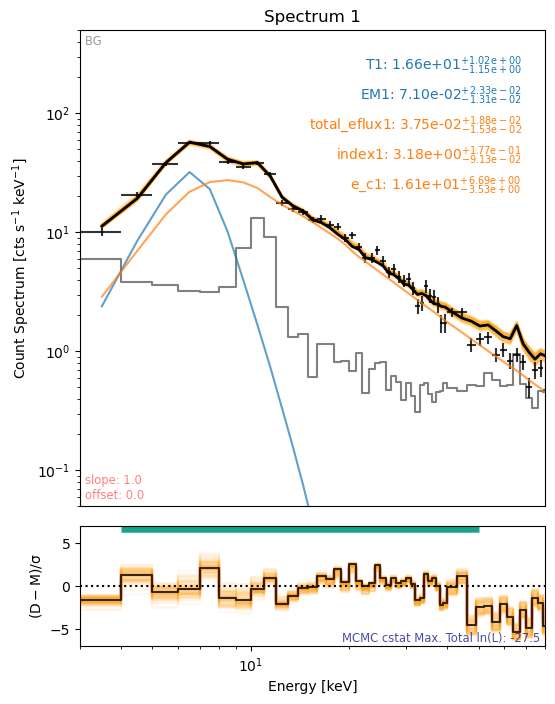

In [16]:
# Plot the spectrum using the mcmc fit results
plt.figure(figsize=spec_single_plot_size)
axes, res_axes = fitter.plot()
for a in axes:
    a.set_xlim(xlims)
    a.set_ylim(ylims)
    a.set_xscale("log")
plt.show()

------

In [17]:
# Let's extract all the info and make a nicer plot
# Note this only work in the current version of sunxspex.....
# Get all the fit parameters
tmk=fitter.params["T1_spectrum1"]['Value']
tmk_ci=[tmk-fitter.params["T1_spectrum1"]['Error'][0],tmk+fitter.params["T1_spectrum1"]['Error'][1]]
em=fitter.params["EM1_spectrum1"]['Value']*1e46
em_ci=[em-fitter.params["EM1_spectrum1"]['Error'][0]*1e46,\
    em+fitter.params["EM1_spectrum1"]['Error'][1]*1e46]
ntot=fitter.params["total_eflux1_spectrum1"]["Value"]*1e35
ntot_err=[fitter.params["total_eflux1_spectrum1"]["Error"][0]*1e35,\
          fitter.params["total_eflux1_spectrum1"]["Error"][1]*1e35]
ind=fitter.params["index1_spectrum1"]["Value"]
ind_err=[fitter.params["index1_spectrum1"]["Error"][0],fitter.params["index1_spectrum1"]["Error"][1]]
ec=fitter.params["e_c1_spectrum1"]["Value"]
ec_err=[fitter.params["e_c1_spectrum1"]["Error"][0],fitter.params["e_c1_spectrum1"]["Error"][1]]

# Make them look nice for the plot
tmks=f'{tmk:4.2f}'
tmkups=f'{tmk_ci[1]-tmk:4.2f}'
tmkdns=f'{tmk-tmk_ci[0]:4.2f}'
ems=f'{em*1e-46:4.2f}'
emups=f'{(em_ci[1]-em)*1e-46:4.2f}'
emdns=f'{(em-em_ci[0])*1e-46:4.2f}'
nts=f'{ntot*1e-35:4.2f}'
ntups=f'{ntot_err[1]*1e-35:4.2f}'
ntdns=f'{ntot_err[0]*1e-35:4.2f}'
inds=f'{ind:4.2f}'
indups=f'{ind_err[1]:4.2f}'
inddns=f'{ind_err[0]:4.2f}'
ecs=f'{ec:4.2f}'
ecups=f'{ec_err[1]:4.2f}'
ecdns=f'{ec_err[0]:4.2f}'

# Get the data and fits to replot
engs=fitter.plotting_info['spectrum1']['count_channels']
edels=fitter.plotting_info['spectrum1']['count_channel_error']
rat=fitter.plotting_info['spectrum1']['count_rates']
erat=fitter.plotting_info['spectrum1']['count_rate_errors']
# Currently background returns same values twice ?!?!?! like resid
backrat=fitter.plotting_info['spectrum1']['background_rate'][::2]
resid=fitter.plotting_info['spectrum1']['residuals'][::2]
fmd=fitter.plotting_info['spectrum1']['count_rate_model']
sfmd=fitter.plotting_info['spectrum1']['submodels']
fiter=fitter.plotting_info['spectrum1']['fitting_range']
# Sort out the energy binning steps for plotting
stepe = list()
for i in range(len(engs)):
    stepe.append(engs[i] - edels[i])
stepe.append(engs[-1]+edels[-1])
ns=len(stepe)

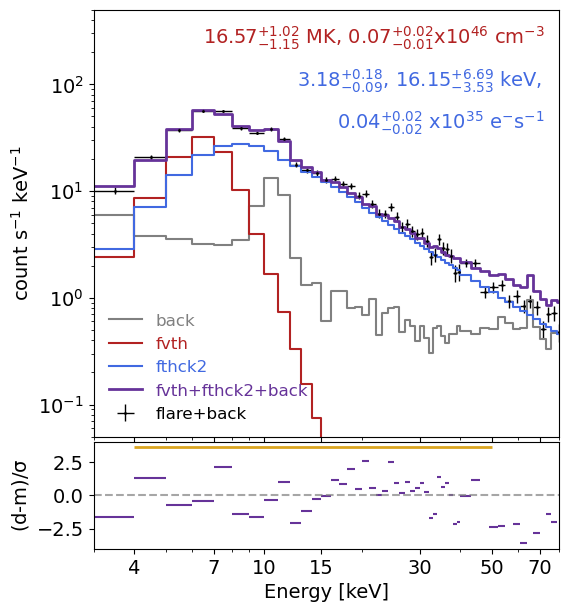

In [18]:
# Now do a nicer plot
# With x-axis log labels again
plt.rcParams['font.size'] = 14
yrlim=[-4,4]
xlim=[3,80]
ylim= [5e-2,5e2]
gs_kw = dict(height_ratios=[4,1],hspace=0.02,wspace=0.05)
fig, axs = plt.subplots(ncols=1, nrows=2, constrained_layout=False,
                             gridspec_kw=gs_kw,figsize=(6,7))

axs[0].errorbar(engs,rat,xerr=edels,yerr=erat,fmt='.',color='k',lw=1.,ms=2,label='flare+back')
axs[0].step(stepe[0:ns-1],backrat,where='post',color='grey',lw=1.5,label='back')
axs[0].step(stepe[0:ns-1],sfmd[0][0:ns-1],where='post',color='firebrick',label='fvth')
axs[0].step(stepe[0:ns-1],sfmd[1][0:ns-1],where='post',color='royalblue',label='fthck2')
axs[0].step(stepe[0:ns-1],fmd[0:ns-1],where='post',color='rebeccapurple',lw=2,label='fvth+fthck2+back')
axs[0].legend(loc=3,labelcolor='linecolor',frameon=False,prop={'size': 12})
axs[0].text(0.97,0.92,tmks+'$^{+'+tmkups+'}_{-'+tmkdns+'}$ MK, '+\
            ems+'$^{+'+emups+'}_{-'+emdns+'}$x10$^{46}$ cm$^{-3}$',\
              color='firebrick',ha='right',transform=axs[0].transAxes)

axs[0].text(0.97,0.82,inds+'$^{+'+indups+'}_{-'+inddns+'}$, '+\
            ecs+'$^{+'+ecups+'}_{-'+ecdns+'}$ keV, ',
              color='royalblue',ha='right',transform=axs[0].transAxes)
axs[0].text(0.97,0.72,nts+'$^{+'+ntups+'}_{-'+ntdns+'}$ x10$^{35}$ e$^{-}$s$^{-1}$',\
              color='royalblue',ha='right',transform=axs[0].transAxes)
axs[1].hlines(resid,stepe[0:-1],stepe[1:],color='rebeccapurple',lw=1.5)

axs[0].set_ylabel('count s$^{-1}$ keV$^{-1}$')

axs[0].set_ylabel('count s$^{-1}$ keV$^{-1}$')
axs[0].set_xlabel(" ")
axs[0].set_yscale("log")
axs[0].set_ylim(ylim)


axs[1].set_ylabel(r"(d-m)/$\sigma$")
axs[1].set_ylim(yrlim)
axs[1].set_xlabel("Energy [keV]")
axs[1].hlines(0.0,xlims[0],xlims[1],color='grey',linestyle="--",alpha=0.7)
axs[1].hlines(yrlim[1]*0.9,fiter[0],fiter[1],color='goldenrod',lw=2)

for aaxx in axs:
    aaxx.set_xlim(xlim)
    aaxx.set_xscale("log")
    aaxx.set_xticks([4,7,10,15,30,50,70])
    aaxx.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_xticklabels([])
plt.show()

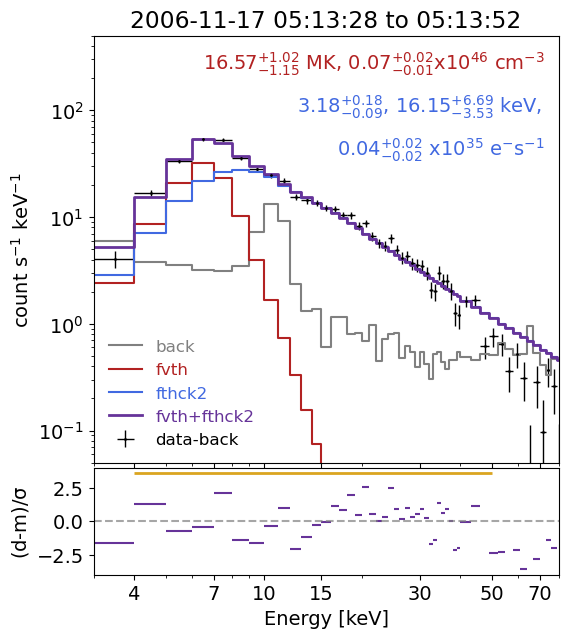

In [19]:
# Do the more standard plot of data-background
# Now do a nicer plot with x-axis log labels again
yrlim=[-4,4]
ylim=[5e-2,5e2]
xlim=[3,80]
plt.rcParams['font.size'] = 14
gs_kw = dict(height_ratios=[4,1],hspace=0.02,wspace=0.05)
fig, axs = plt.subplots(ncols=1, nrows=2, constrained_layout=False,
                             gridspec_kw=gs_kw,figsize=(6,7))

axs[0].errorbar(engs,rat-backrat,xerr=edels,yerr=erat,fmt='.',color='k',lw=1.,ms=2,label='data-back')
axs[0].step(stepe[0:ns-1],backrat,where='post',color='grey',lw=1.5,label='back')
axs[0].step(stepe[0:ns-1],sfmd[0][0:ns-1],where='post',color='firebrick',label='fvth')
axs[0].step(stepe[0:ns-1],sfmd[1][0:ns-1],where='post',color='royalblue',label='fthck2')
axs[0].step(stepe[0:ns-1],sfmd[0][0:ns-1]+sfmd[1][0:ns-1],where='post',color='rebeccapurple',lw=2,label='fvth+fthck2')
axs[0].legend(loc=3,labelcolor='linecolor',frameon=False,prop={'size': 12})
axs[0].text(0.97,0.92,tmks+'$^{+'+tmkups+'}_{-'+tmkdns+'}$ MK, '+\
            ems+'$^{+'+emups+'}_{-'+emdns+'}$x10$^{46}$ cm$^{-3}$',\
              color='firebrick',ha='right',transform=axs[0].transAxes)

axs[0].text(0.97,0.82,inds+'$^{+'+indups+'}_{-'+inddns+'}$, '+\
            ecs+'$^{+'+ecups+'}_{-'+ecdns+'}$ keV, ',
              color='royalblue',ha='right',transform=axs[0].transAxes)
axs[0].text(0.97,0.72,nts+'$^{+'+ntups+'}_{-'+ntdns+'}$ x10$^{35}$ e$^{-}$s$^{-1}$',\
              color='royalblue',ha='right',transform=axs[0].transAxes)
axs[1].hlines(resid,stepe[0:-1],stepe[1:],color='rebeccapurple',lw=1.5)

axs[0].set_ylabel('count s$^{-1}$ keV$^{-1}$')
axs[0].set_xlabel(" ")
axs[0].set_yscale("log")
axs[0].set_ylim(ylim)
axs[0].set_title(ftims.iso[0][:-4]+' to '+ftims.iso[1][11:-4])

axs[1].set_ylabel(r"(d-m)/$\sigma$")
axs[1].set_ylim(yrlim)
axs[1].set_xlabel("Energy [keV]")
axs[1].hlines(0.0,xlims[0],xlims[1],color='grey',linestyle="--",alpha=0.7)
axs[1].hlines(yrlim[1]*0.9,fiter[0],fiter[1],color='goldenrod',lw=2)

for aaxx in axs:
    aaxx.set_xlim(xlim)
    aaxx.set_xscale("log")
    aaxx.set_xticks([4,7,10,15,30,50,70])
    aaxx.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_xticklabels([])
# plt.savefig('nice_plot.pdf',bbox_inches='tight')
plt.show()